# Image denoising by a supervised learning 

In [1]:
import os
from pyexpat import model
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import statistics

In [2]:
from MyDataset import MyDataset
from MyEval import MyEval
from MyModel import MyModel
from MyResult import MyResult
from MyTrain import MyTrain

## construct dataset for training (split=`mytrain` should be used)

In [3]:
dataset = MyDataset(path='data', split='mytrain')

## construct dataloader

In [4]:
batch_size = 64 # you can change this value
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## plot the dataset

In [5]:
iter_data       = iter(dataloader)
(data, label)   = next(iter_data)
print(data.shape, label.shape)
print(data.dtype, label.dtype)

torch.Size([64, 1, 16, 16]) torch.Size([64])
torch.float32 torch.int64


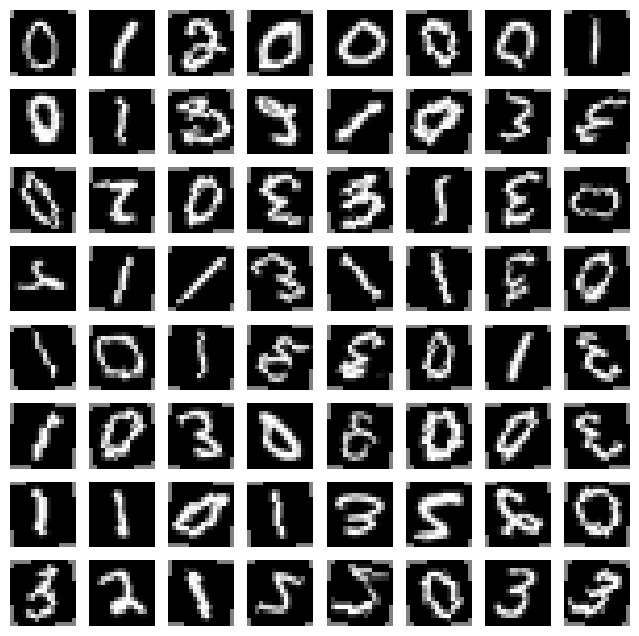

In [6]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(data[idx].squeeze(0), cmap='gray')
plt.show()

## plot the noisy dataset

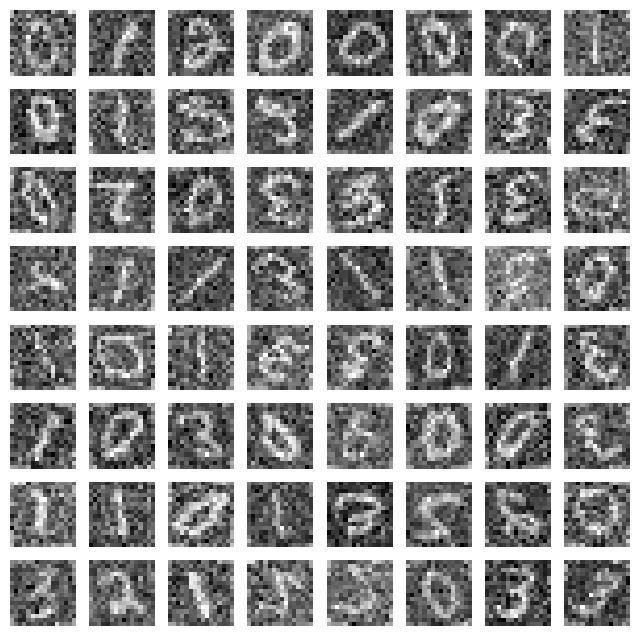

In [7]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        im = data[idx] + torch.randn_like(data[idx]) * 0.5
        plt.imshow(im.squeeze(0), cmap='gray') 
plt.show()

## construct model

In [16]:
model       = MyModel()
size_model  = model.size()
pred        = model(data)
print(f'data: {data.shape}')
print(f'output: {pred.shape}')
print('model size =', size_model)

data: torch.Size([10, 1, 16, 16])
output: torch.Size([10, 1, 16, 16])
model size = 185473


## train

In [17]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.0001,weight_decay=1e-5)
epochs = 200
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=10,       
)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for step, (data,_) in enumerate(dataloader):
        optimizer.zero_grad()
        noise   = torch.randn_like(data) * 0.5
        noised_image = data + noise
        denoised_image = model(noised_image)
        loss = criterion(denoised_image,data)
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(dataloader)
    scheduler.step(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")


Epoch [1/200], Loss: 8.905871
Epoch [2/200], Loss: 5.619403
Epoch [3/200], Loss: 3.420589
Epoch [4/200], Loss: 2.087824
Epoch [5/200], Loss: 1.408897
Epoch [6/200], Loss: 1.019550
Epoch [7/200], Loss: 0.801213
Epoch [8/200], Loss: 0.669498
Epoch [9/200], Loss: 0.598242
Epoch [10/200], Loss: 0.553252
Epoch [11/200], Loss: 0.501412
Epoch [12/200], Loss: 0.484755
Epoch [13/200], Loss: 0.464695
Epoch [14/200], Loss: 0.459292
Epoch [15/200], Loss: 0.441283
Epoch [16/200], Loss: 0.430567
Epoch [17/200], Loss: 0.416166
Epoch [18/200], Loss: 0.423851
Epoch [19/200], Loss: 0.403505
Epoch [20/200], Loss: 0.408743
Epoch [21/200], Loss: 0.386006
Epoch [22/200], Loss: 0.404637
Epoch [23/200], Loss: 0.381070
Epoch [24/200], Loss: 0.375142
Epoch [25/200], Loss: 0.368035
Epoch [26/200], Loss: 0.362655
Epoch [27/200], Loss: 0.356322
Epoch [28/200], Loss: 0.366689
Epoch [29/200], Loss: 0.363739
Epoch [30/200], Loss: 0.349492
Epoch [31/200], Loss: 0.363573
Epoch [32/200], Loss: 0.354796
Epoch [33/200], L

## save the trained model

In [18]:
model.eval()
model.save()    # save the trained model in 'model.pth'

## load the trained model

In [19]:
model = MyModel()   # model should not require any argument!
model.load()
model.eval()

MyModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

## evaluation

In [20]:
eval    = MyEval()
result  = MyResult()

## evaluation of the trained model on the training dataset (split=`train`)

In [21]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='train') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)

eval.psnr_reset()
for step, (data, _) in enumerate(tqdm(dataloader)):
    noise   = torch.randn_like(data) * 0.5
    input   = data + noise
    output  = model(input)
    eval.psnr_update(output, data)

psnr_value = eval.psnr_compute()
result.add_result('train', psnr_value)
print(f'PSNR (train): {psnr_value}')

  0%|          | 0/40 [00:00<?, ?it/s]

PSNR (train): 33.961368560791016


## evaluation of the trained model on the validation dataset (split=`val`)

In [22]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='val') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)

eval.psnr_reset()
for step, (data, _) in enumerate(tqdm(dataloader)):
    noise   = torch.randn_like(data) * 0.5
    input   = data + noise
    output  = model(input)
    eval.psnr_update(output, data)

psnr_value = eval.psnr_compute()
result.add_result('val', psnr_value)
print(f'PSNR (val): {psnr_value}')

  0%|          | 0/10 [00:00<?, ?it/s]

PSNR (val): 34.4941520690918


## save the result

In [23]:
result.save()